In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.2.0


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
print('train data shape:', train_data.shape)
print('test data shape:', test_data.shape)

train data shape: (1460, 81)
test data shape: (1459, 80)


In [4]:
train_data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# 除去id列和训练集的预测属性列，将训练集和测试集上写拼接，方便做特征预处理
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.shape)

(2919, 79)


In [6]:
# 预处理数据

# 选取特征类型为数值型的特征，作归一化处理和缺失值处理
numerical_features = all_features.dtypes[all_features.dtypes != 'object'].index
# print(numerical_features)

all_features[numerical_features] = all_features[numerical_features].apply(lambda x: (x-x.mean())/ (x.std()))
all_features[numerical_features] = all_features[numerical_features].fillna(0)

In [7]:
# 对类目性特征进行处理, 独热编码
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [8]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype = torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype = torch.float)

train_labels = torch.tensor(train_data.SalePrice.values, dtype = torch.float).view(-1, 1)

In [9]:
print(train_features.shape)

torch.Size([1460, 331])


In [10]:
# train model

loss = torch.nn.MSELoss()
def get_net(feature_num):
    net = nn.Linear(feature_num, 1) # Linear(in_features, out_features)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01) # 初始化权值
    return net


# 用来评价模型，所以不需要记录梯度
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1， 使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

In [11]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
#     print(type(dataset))
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls


In [12]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid


In [14]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k


<class 'torch.utils.data.dataset.TensorDataset'>
fold 0, train rmse 3.729536, valid rmse 3.746261
<class 'torch.utils.data.dataset.TensorDataset'>
fold 1, train rmse 3.741102, valid rmse 3.749780
<class 'torch.utils.data.dataset.TensorDataset'>
fold 2, train rmse 3.734652, valid rmse 3.751113
<class 'torch.utils.data.dataset.TensorDataset'>
fold 3, train rmse 3.746527, valid rmse 3.722388
<class 'torch.utils.data.dataset.TensorDataset'>
fold 4, train rmse 3.731947, valid rmse 3.736734
5-fold validation: avg train rmse 3.736753, avg valid rmse 3.741255


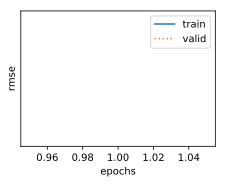

In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5, 1, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

In [138]:
x=torch.empty(2,2)
y = torch.tensor([1,2])
print(y.size())
print(x.size())
clipped_preds = torch.max(y, torch.tensor([1.0]))
print(torch.tensor(1.0).size())
print(clipped_preds)



torch.Size([2])
torch.Size([2, 2])


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'other'

In [136]:
torch.sqrt(1,2)

TypeError: sqrt() takes 1 positional argument but 2 were given